# Libraries

In [1]:
import psutil
psutil.virtual_memory() 

svmem(total=540408946688, available=525807316992, percent=2.7, used=11078758400, free=527296139264, active=825081856, inactive=3593904128, buffers=3833856, cached=2030215168, shared=572657664, slab=1167568896)

In [2]:
from datetime import datetime

import numpy as np
import pandas as pd
from numpy import array

from os import listdir
from os.path import isfile, join
import glob

import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import cmocean
##from mpl_toolkits.basemap import Basemap

from matplotlib import ticker
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from cartopy.mpl.ticker import LongitudeFormatter


import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import scipy as _sp

import scipy.linalg as sc
import numpy.linalg as lin

In [3]:
from scipy.spatial import distance

from scipy.signal import argrelextrema
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

#%pdb
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import klus.algorithms as al
import klus.kernels as kernels
# import d3s.tools as tools
# import d3s.domain as domain

In [5]:
import zapata.computation as zcom
import zapata.data as zdat
import zapata.lib as zlib
import zapata.mapping as zmap
import zapata.koopman as zkop

import cftime

# Definition of functions

## Definition order_w

In [ ]:
def order_w(w,option='magnitude',direction='up'):
    '''
    Order Eigenvalues according to 
    option
    'magnitude'         abs(w)
    'frequency'         w.imag
    'growth'            w.real
    'ones'              abs(w) closest to 1.0
    
    direction
    'up'               descending
    'down'             ascending
    
    '''
    print(' Ordering Eigenvalues as ', option, ' with direction ',direction)
    w_cont = np.log(w)
    if option == 'magnitude':
        ind=abs(w).argsort()
    elif option == 'frequency':
        ind=abs(w_cont.imag).argsort()
    elif option == 'growth':
        ind=np.abs(w_cont.real - 0.0).argsort()
    elif option == 'one':
        ind=np.abs(np.abs(w) - 1.0).argsort()
    else:
        print(' Error in oder_w', option, direction)
# Choose direction
    if direction == 'up':
        indu=ind[::-1]
    else:
        indu=ind

    w0=w[indu]
    w1=w_cont[indu]
    return w0,w1,indu


## Definition function evolve and verify

In [ ]:
def evolve(tim_level,tstep,init_date):
    #tim_level=[0,1,2,3,4,5,6]
    #cases =  216,228,240, 36,48,60,  360,372,384
    #tstep=3
    #nstart=360
    x0=PsiX[:,init_date]
    ht=np.zeros([x0.shape[0],len(tim_level)],dtype='complex')
    for j in tim_level:
        D = np.diag(vw_s[:nmode]**(j*tstep))                  # w --> vw_s
        ht[:,j]=alpha@D@vcut.T@Gxx[init_date,:] 
    return ht

#verify to EOF expansion  (spatial correlation)
def verify(tim_level,tstep,init_date,PCs,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        kaz2=PCs[:,int(init_date+neig*tstep)]
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz2, axis=1)
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp[:,0])[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab


#verify to total data
def verify_tot(tim_level,tstep,init_date,X,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = X.A.data[:, int(init_date+neig*tstep)]
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp)[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab

## Definition dates2years

In [ ]:
def date2year(years,init_year,date):
    """Transform index date ['Jan' '1989' ] in index i.
    
    Years are from np.arange(1960,2020, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=float(date[4:8])
    m=mon.index(str(date[0:3]))
    index = (y-init_year)*12 + m
    return int(index)

In [ ]:
def year2date(years,i):
    """ Transform index i in string date yy/mm.
    
    Rounding requires the small shift
    Years are obtained from np.arange(1920,2018, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=str(int(years[i]+0.001))
    m=np.mod(int(round((years[i]-int(years[i]))*12)),12)
    date = mon[m] + ' ' + y
    return date

## Definition eigenvalues on points

In [6]:
def eigenfunction_value(cc, KK_tot, x, mode ):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    f = 0
    for i in range(KK_tot.ntime):
        f +=  cc[i,mode]*k(x, KK_tot.PsiX[:, i])       #somma per tutti i tempo: componente del modo (colonna) per kernel(initial condition x, fila PsiX)
    return f

In [6]:
def eigenfunction_value_opt1(cc, KK_tot, x):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    ntime = KK_tot.ntime
    PsiX = KK_tot.PsiX

    # Precompute k(x, PsiX) to avoid redundant calculations
    k_values = np.array([k(x, PsiX[:, i]) for i in range(ntime)])

    f = np.dot(k_values,cc)  # Use NumPy dot product for summation
    return f

## Definition sigma cost function

In [7]:
from scipy.optimize import minimize_scalar

In [8]:
def cost(x):
    ss = str(x)
    KK_tot.fit(bandwidth=ss)
    KMM = sc.pinv(KK_tot.vv)@(KK_tot.PsiX.T)
    return sum(lin.norm(KK_tot.vv@KMM-KK_tot.PsiX.T, axis=0))

# Load and regrid data

In [6]:
#CMIP Jakob
ds_tos = xr.open_dataarray("CESM_data/regridded_tos.nc")
ds_ssh = xr.open_dataarray("CESM_data/regridded_ssh.nc")

In [7]:
ds_tos

<xarray.DataArray (time: 24000, lat: 180, lon: 360)>
[1555200000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 ...
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
Attributes:
    regrid_method:  bilinear

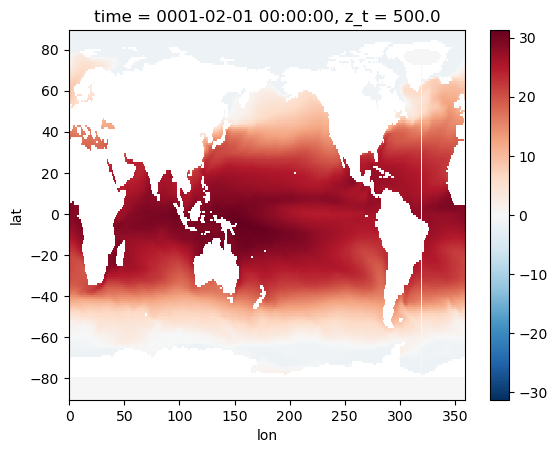

In [8]:
ds_tos.isel(time=0).plot()

## Subset data

In [9]:
#  Read Variable
area='Jakob'
if area == 'TROPIC':
    # central pacific coordinates
    arealat=(35,-35)
    arealon=[-180, 180.]
elif area == 'GLOBAL':
    arealat=(60,-60)
    arealon=[-160,110.]
elif area == 'WORLD':
    arealat=(60,-60)
    arealon=[-180,180.]
elif area == 'NAVARRA_2021':
    arealat=(-15,15)
    arealon=[140,290.]
elif area == 'Jakob':
    arealat=(-31,32)
    arealon=[130,290.]
else:
    Print(f'No area ')
    
case = 'UNIT'    
data_name= 'CESM'
variable='SST'
lev = 'SURF'
shift = 'ERA5'
period = 'ANN'
normalization = 'anom'

# Use SVD encoding
encode_svd = True
#Choose number of SVD to ratain
var_retained = None #None# Variance retained or None for full rank
#Option to write files
write_files = False

In [10]:
S_tos = ds_tos.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))
S_ssh = ds_ssh.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))

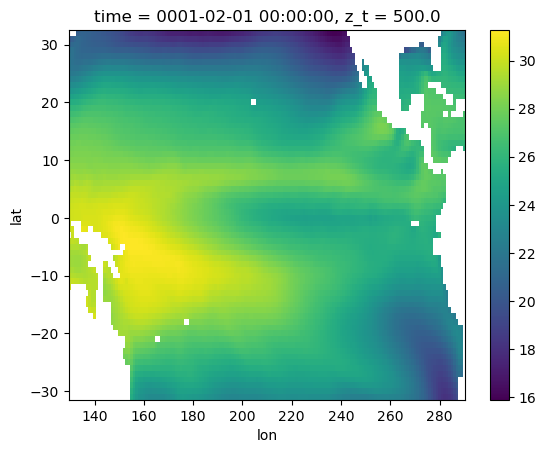

In [11]:
S_tos.isel(time=0).plot()

In [12]:
del(ds_tos, ds_ssh)

In [13]:
import psutil
psutil.virtual_memory() 

svmem(total=540408946688, available=525588074496, percent=2.7, used=11296772096, free=527075667968, active=827523072, inactive=3809345536, buffers=3833856, cached=2032672768, shared=572661760, slab=1167675392)

## Create matrices, de-trending data and anomalies

In [14]:
#Create Xmats
X_tos=zcom.Xmat(S_tos,dims=('lat','lon'))
X_tos.A = X_tos.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [15]:
X_ssh=zcom.Xmat(S_ssh,dims=('lat','lon'))
X_ssh.A = X_ssh.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [16]:
del(S_tos,S_ssh)

In [17]:
#Detrending
X_tos.detrend(axis=1)
X_ssh.detrend(axis=1)

Detrending data with options -->  {'axis': 1}
Detrending data with options -->  {'axis': 1}


In [18]:
#Anomalies
X_tos.anom(option='anomstd',freq='month')
X_ssh.anom(option='anomstd',freq='month')

In [19]:
X_tos

 
 Math Data Matrix 
 <xarray.DataArray (z: 9121, time: 24000)>
array([[ 0.39702395, -0.6189652 , -0.85483867, ...,  0.01754726,
         0.4485007 ,  0.45266727],
       [ 0.1696403 , -0.8670136 , -0.82748204, ..., -0.18566637,
         0.30663636,  0.0749752 ],
       [ 0.04911598, -0.8939764 , -0.6554643 , ..., -0.32772142,
         0.22505376, -0.1466265 ],
       ...,
       [ 0.39432192,  0.8016582 ,  0.8832131 , ..., -0.28593224,
        -0.38302863, -0.2468319 ],
       [ 0.2645133 ,  0.6563553 ,  0.84212416, ..., -0.36678267,
        -0.34379554, -0.21504594],
       [ 0.13001835,  0.5547301 ,  0.77214986, ..., -0.3915147 ,
        -0.32304496, -0.17562436]], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
  * z        (z) object MultiIndex
  * lat      (z) float64 -31.0 -31.0 -31.0 -31.0 -31.0 ... 32.0 32.0 32.0 32.0
  * lon      (z) int64 155 156 157 158 159 160 161 ... 285 286 287 288 289 290
    

# Compute general EOFs

In [ ]:
##################################################################
############# SELECT DATA AND COMPUTE EOFs #######################
##################################################################
X_tos_sel=X_tos.A
X_ssh_sel=X_ssh.A


## Compute EOFs
### SST
xdat = X_tos_sel.data
if encode_svd:
    udatx, sdatx, vhdatx = sc.svd(xdat[:,:], full_matrices=False)

    if not var_retained:
        mr=lin.matrix_rank(xdat)
        print(f'  Number of SVD modes set to Rank {mr}')
    else:
        mr = np.min(np.where(np.cumsum(sdatx**2/sum(sdatx**2)) > var_retained -0.001))
        print(f'  Number of SVD modes retained {mr}')
    var = sdatx**2
    print(f'Variance Retained {sum(sdatx[0:mr]**2)/sum(var):.4f}')

mr = lin.matrix_rank(xdat)     #31
var = sdatx**2
print(sum(sdatx[0:mr]**2)/sum(var))

#Standardize Coefficients and Reduce dimensionality via an EOF encoding
#keep only mr modes
udat_sst=udatx[:,0:mr]
sdat_sst=sdatx[0:mr]
# the columns of vhdatx contain the coefficients of the field (standardized to unit variance)
vhdat_sst=vhdatx[0:mr,:]
# coffieints non standardized directly from projection on EOF
vdat_sst=udat_sst.T.conj() @ xdat

### SSH
xdat = X_ssh_sel.data
if encode_svd:
    udatx, sdatx, vhdatx = sc.svd(xdat[:,:], full_matrices=False)

    if not var_retained:
        mr=lin.matrix_rank(xdat)
        print(f'  Number of SVD modes set to Rank {mr}')
    else:
        mr = np.min(np.where(np.cumsum(sdatx**2/sum(sdatx**2)) > var_retained -0.001))
        print(f'  Number of SVD modes retained {mr}')
    var = sdatx**2
    print(f'Variance Retained {sum(sdatx[0:mr]**2)/sum(var):.4f}')

mr = lin.matrix_rank(xdat)     #31
var = sdatx**2
print(sum(sdatx[0:mr]**2)/sum(var))

#Standardize Coefficients and Reduce dimensionality via an EOF encoding
#keep only mr modes
udat_ssh=udatx[:,0:mr]
sdat_ssh=sdatx[0:mr]
# the columns of vhdatx contain the coefficients of the field (standardized to unit variance)
vhdat_ssh=vhdatx[0:mr,:]
# coffieints non standardized directly from projection on EOF
vdat_ssh=udat_ssh.T.conj() @ xdat


In [ ]:
#Choose number of EOFs for each variable
nEOF_SST= 845
nEOF_D20= 1000
nEOF_WS= 0

#insert nº of EOFs retained, limit of the training period, tau0 and number of lags
nEOF= nEOF_SST + nEOF_D20 + nEOF_WS     #23

In [ ]:
# Select just X first EOFs
data_SST= vdat_sst[0:nEOF_SST,:]
data_SSH= vdat_ssh[0:nEOF_D20,:]

EOFs_SST= udat_sst[:,0:nEOF_SST]
EOFs_SSH= udat_ssh[:,0:nEOF_D20]

PCs=np.concatenate((data_SST,data_SSH), axis=0)
EOFs_sst_ssh=np.concatenate((EOFs_SST,EOFs_SSH), axis=1)

PCs=PCs.astype('float64')
print(PCs.shape)
print(EOFs_sst_ssh.shape)

In [ ]:
np.save('Processed_data/PCs_CESM_20SST_10SSH', PCs, allow_pickle=True, fix_imports=True)
np.save('Processed_data/EOFs_CESM_20SST_10SSH', EOFs_sst_ssh, allow_pickle=True, fix_imports=True)

In [ ]:
np.save('Processed_data/PCs_CESM_845SST_1000SSH', PCs, allow_pickle=True, fix_imports=True)
np.save('Processed_data/EOFs_CESM_845SST_1000SSH', EOFs_sst_ssh, allow_pickle=True, fix_imports=True)

In [ ]:
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [ ]:
print(PCs.shape)
print(EOFs.shape)

# Compute optimal stds and Giannakis optimization

In [23]:
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [24]:
giann= np.zeros([2,66])
giann.shape

(2, 66)

In [25]:
chunks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65]
#chunks

In [26]:
from sklearn.neighbors import NearestNeighbors

In [27]:
options = {'operator': 'Koopman', 
               'kernel_choice': 'gauss',
               'bandwidth': 'std',
               'epsilon': 1e-5}

In [28]:
PCs.shape

(1845, 24000)

In [29]:
encode_svd=True
for m in chunks:

    ##################################################################
    ############# SELECT DATA AND COMPUTE EOFs #######################
    ##################################################################
    nchunk=chunks[m]
    print(nchunk)
    
    ##################################################################
    #############         SIGMA AND STD         ######################
    ##################################################################

    PCs_sel=PCs[:,nchunk*360:360+nchunk*360]
    
    # Sigma optimization
    KK_tot=zkop.Koop(PCs_sel,**options)

    #result = minimize_scalar(cost, bounds=(10,150), method='Bounded',options={'disp':3,'xatol':0.001})
    #giann[0,m]=result.x
    
    # Std
    similarity=distance.squareform(distance.pdist(KK_tot.PsiX.T ,'sqeuclidean'))
    scale=np.std(similarity.flatten())
    std=np.sqrt(scale/2)
    giann[0,m]=std
    
    ##################################################################
    #############         GIANNAKIS          ######################
    ##################################################################

    if encode_svd:
        nbrs = NearestNeighbors(n_neighbors=PCs_sel.shape[1], algorithm='auto', radius=10).fit(PCs_sel.T)
        distances, _ = nbrs.kneighbors(PCs_sel.T)
    else:
        nbrs = NearestNeighbors(n_neighbors=xdat.shape[1], algorithm='auto', radius=10).fit(xdat.T)
        distances, _ = nbrs.kneighbors(xdat.T)

    # Compute bandwidth according to Giannakis paper

    nn=np.mean(distances)/np.sqrt(2.)
    print(f' Giannakis {nn*2}, our paper {2*42**2}, equivalent sigma to giannakis {np.sqrt(nn**2/2)}'  )
    giann[1,m]=np.sqrt(nn**2/2)

0
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Giannakis 272.730131138082, our paper 3528, equivalent sigma to giannakis 96.42466258081708
1
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Giannakis 254.29158261429345, our paper 3528, equivalent sigma to giannakis 89.90565123261304
2
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Giannakis 269.2808205010175, our paper 3528, equivalent sigma to giannakis 95.20514710987348
3
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Giannakis 250.46651471765773, our paper 3528, equivalent sigma to giannakis 88.553285508508
4
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Giannakis 255.51302292492971, our paper 3528, equivalent sigma to giannakis 90.3374955958458
5
Created Koopman Estimator 
 for 359 samples and 1845 features,  

In [30]:
giann

array([[ 94.44745476,  87.64152363, 106.76932773,  84.06159577,
         93.80340353,  93.57218929, 108.13593071,  89.84622054,
         86.71050674,  94.20472491,  82.91874701,  91.14307614,
         86.1823076 ,  80.5459038 ,  95.70973482,  95.92967604,
         90.0242253 , 111.45725162, 104.50219519,  88.40278085,
         81.88421518,  99.43139772,  94.22597327,  82.76488008,
         84.11447939,  80.06394601,  90.95183556,  99.21189415,
         97.80368817,  85.07130263,  91.59237639,  92.01921933,
         83.87457711,  99.81355915,  81.24667238,  93.63584264,
         88.28975642,  96.4944174 ,  95.45070599,  97.10764506,
         85.52763464,  86.80088655,  85.21447656,  84.22778897,
         89.41355501,  94.25707246,  91.78379573,  84.83372445,
         98.56124021,  99.77420756, 116.76890767,  94.47456388,
        105.23003752,  78.09924283,  90.72140973,  93.106397  ,
         90.26799581,  89.25951805, 101.22947879,  82.66425602,
         91.43720226,  88.82358069,  88.

In [31]:
#np.save('Processed_data/stds_giann_100_30EOFs', giann, allow_pickle=True, fix_imports=True)
np.save('Processed_data/stds_giann_30_ALLEOFs', giann, allow_pickle=True, fix_imports=True)

# Compute 20 Gram matrices

In [20]:
encode_svd=True

In [21]:
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
sig=np.load('Processed_data/stds_giann_30_ALLEOFs.npy')
#EOFs=np.load('/home/paulalo/Desktop/Zapata/Boulder/Forecasts Averaged A 100 years/EOFs_CESM_20SST_10SSH.npy')
sig

array([[ 94.44745476,  87.64152363, 106.76932773,  84.06159577,
         93.80340353,  93.57218929, 108.13593071,  89.84622054,
         86.71050674,  94.20472491,  82.91874701,  91.14307614,
         86.1823076 ,  80.5459038 ,  95.70973482,  95.92967604,
         90.0242253 , 111.45725162, 104.50219519,  88.40278085,
         81.88421518,  99.43139772,  94.22597327,  82.76488008,
         84.11447939,  80.06394601,  90.95183556,  99.21189415,
         97.80368817,  85.07130263,  91.59237639,  92.01921933,
         83.87457711,  99.81355915,  81.24667238,  93.63584264,
         88.28975642,  96.4944174 ,  95.45070599,  97.10764506,
         85.52763464,  86.80088655,  85.21447656,  84.22778897,
         89.41355501,  94.25707246,  91.78379573,  84.83372445,
         98.56124021,  99.77420756, 116.76890767,  94.47456388,
        105.23003752,  78.09924283,  90.72140973,  93.106397  ,
         90.26799581,  89.25951805, 101.22947879,  82.66425602,
         91.43720226,  88.82358069,  88.

In [22]:
chunks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65]
#chunks

0
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 96.42466258081708 for a  18595.431107648852 and sigma 96.42466258081708

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


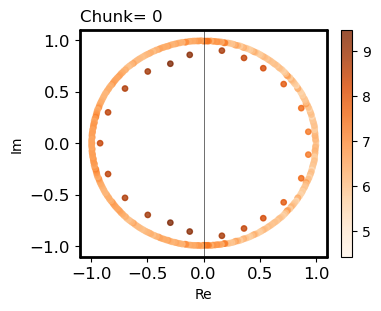

1
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 89.90565123261304 for a  16166.05224712051 and sigma 89.90565123261304

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


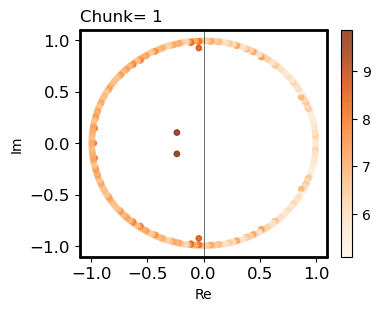

2
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 95.20514710987348 for a  18128.0400724253 and sigma 95.20514710987348

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


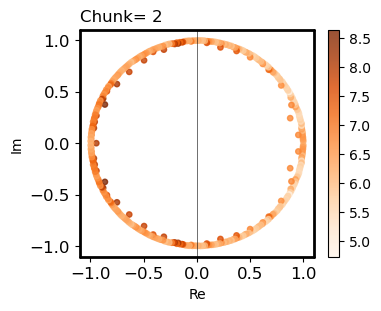

3
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 88.553285508508 for a  15683.368748702665 and sigma 88.553285508508

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


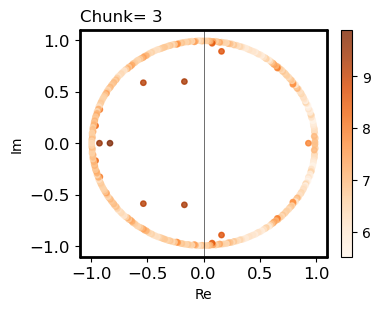

4
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 90.3374955958458 for a  16321.726221058916 and sigma 90.3374955958458

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


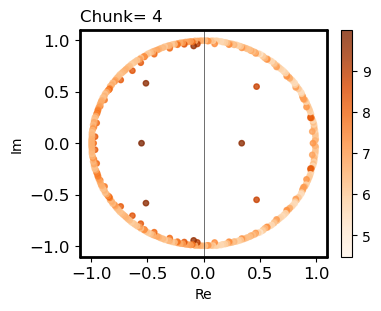

5
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 90.41111281581871 for a  16348.338641189397 and sigma 90.41111281581871

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


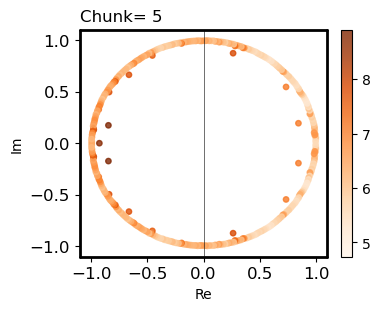

6
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 96.46707139406824 for a  18611.79172669652 and sigma 96.46707139406824

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


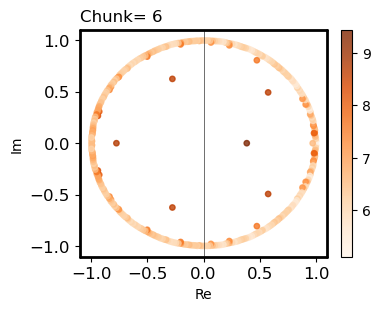

7
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 90.82061488644756 for a  16496.768176704838 and sigma 90.82061488644756

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


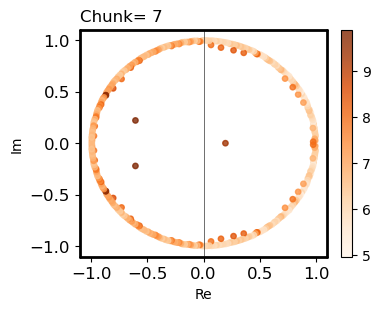

8
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 91.31926783072704 for a  16678.417354280118 and sigma 91.31926783072704

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


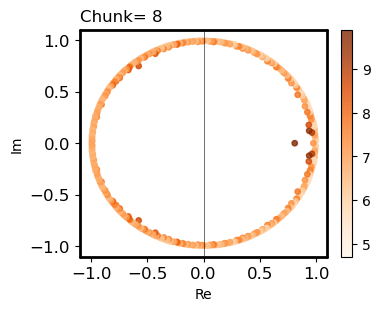

9
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 90.63755989369393 for a  16430.33452696591 and sigma 90.63755989369393

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


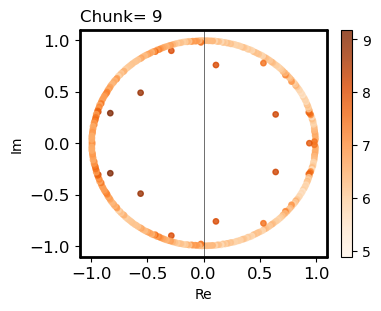

10
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 87.2264698510142 for a  15216.914085339778 and sigma 87.2264698510142

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


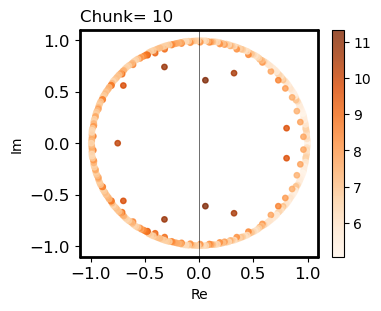

11
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 90.54832743648971 for a  16397.999203091513 and sigma 90.54832743648971

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


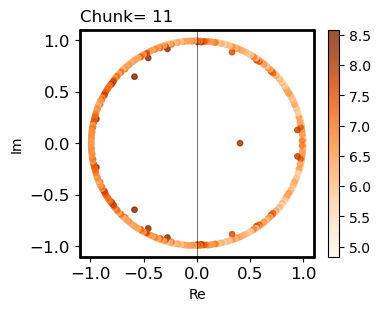

12
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 87.88806544512742 for a  15448.624095374002 and sigma 87.88806544512742

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


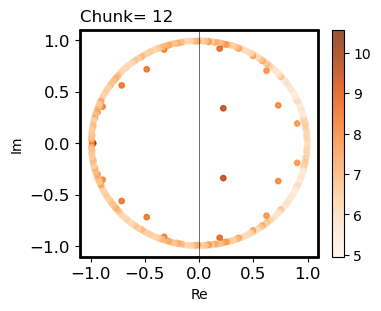

13
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 86.13633441180671 for a  14838.936211805196 and sigma 86.13633441180671

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


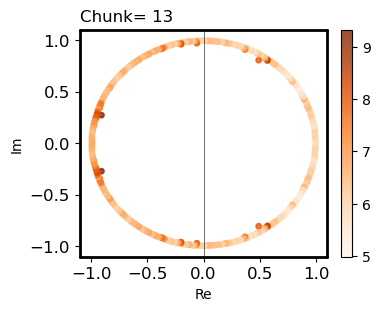

14
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 90.61270558332116 for a  16421.324826259282 and sigma 90.61270558332116

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


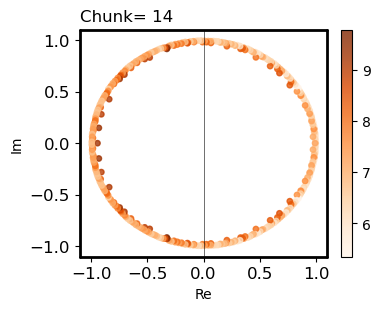

15
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 92.88431169864496 for a  17254.99071946207 and sigma 92.88431169864496

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


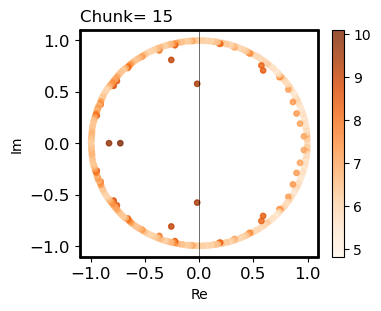

16
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 90.44421618110124 for a  16360.312481227551 and sigma 90.44421618110124

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


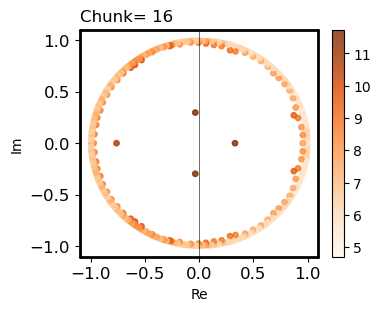

17
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 100.7555883484147 for a  20303.377166870403 and sigma 100.7555883484147

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


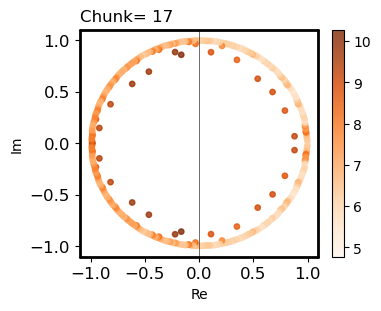

18
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 93.79895437914425 for a  17596.48768524157 and sigma 93.79895437914425

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


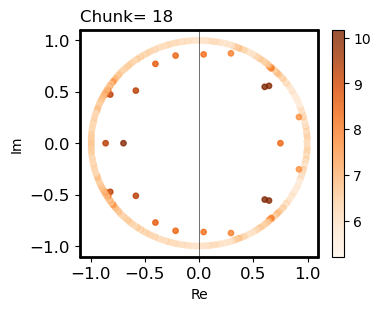

19
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 85.52706533384524 for a  14629.757809239665 and sigma 85.52706533384524

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


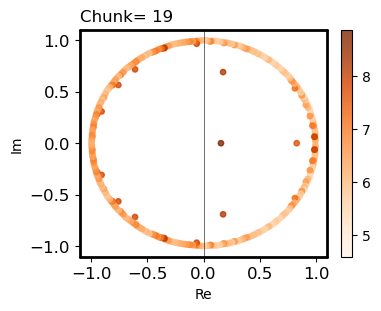

20
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 86.19681380385653 for a  14859.781419873423 and sigma 86.19681380385653

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


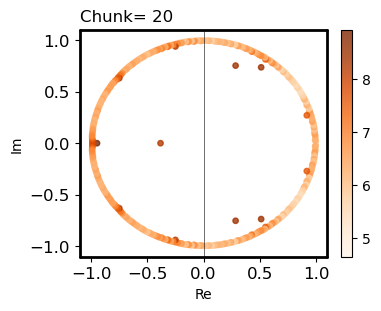

21
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 97.98783724913346 for a  19203.232497525336 and sigma 97.98783724913346

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


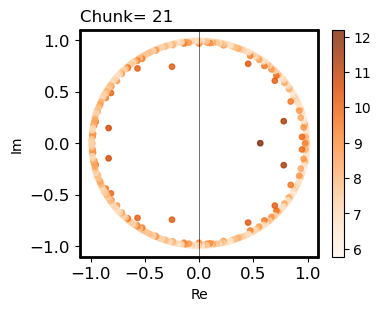

22
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 86.87594717247843 for a  15094.860394230527 and sigma 86.87594717247843

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


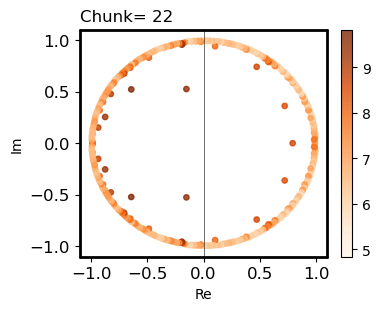

23
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 91.1564722673327 for a  16619.004872449994 and sigma 91.1564722673327

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


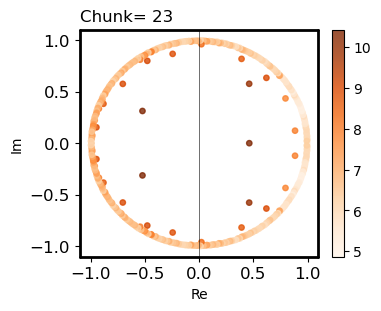

24
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 88.94039161842622 for a  15820.786522478042 and sigma 88.94039161842622

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


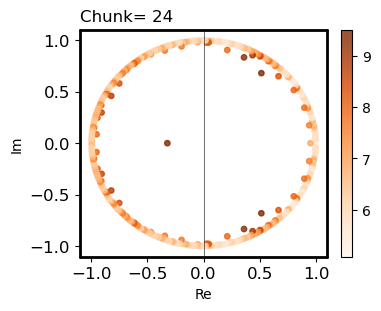

25
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 87.80768339026746 for a  15420.378524730902 and sigma 87.80768339026746

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


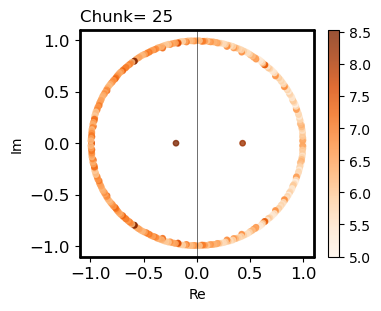

26
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 89.30553065468156 for a  15950.955611028536 and sigma 89.30553065468156

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


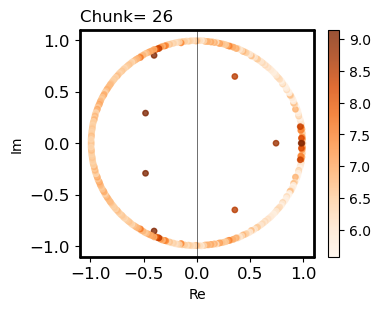

27
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 93.56919900038181 for a  17510.390003146105 and sigma 93.56919900038181

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


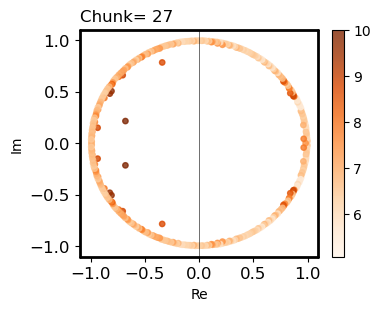

28
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 90.12882822600457 for a  16246.411354785278 and sigma 90.12882822600457

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


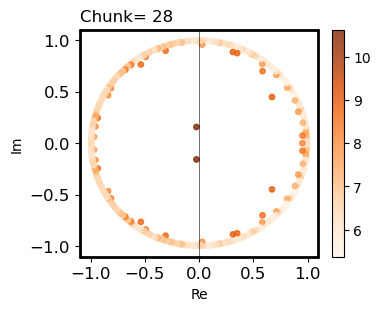

29
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 85.54007726120548 for a  14634.209635706007 and sigma 85.54007726120548

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


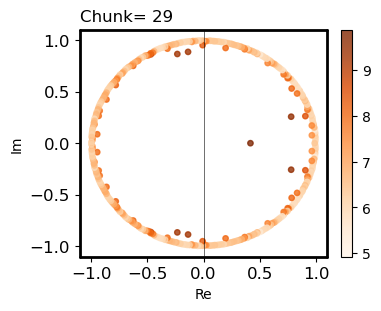

30
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 90.85964005225112 for a  16510.948380849273 and sigma 90.85964005225112

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


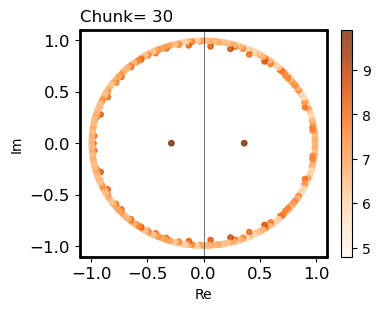

31
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 90.90223406419489 for a  16526.432315723345 and sigma 90.90223406419489

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


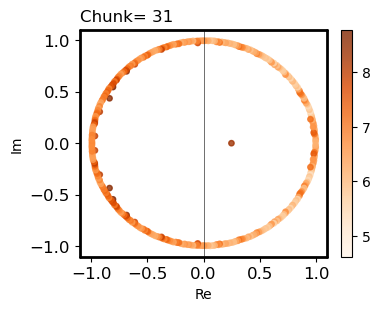

32
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 88.13950816581679 for a  15537.14579942417 and sigma 88.13950816581679

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


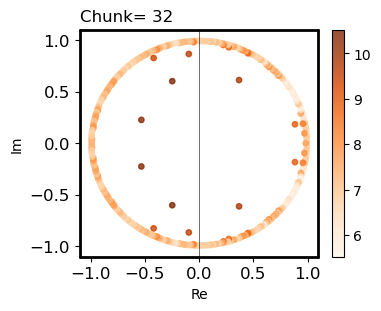

33
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 98.305082223483 for a  19327.778381931505 and sigma 98.305082223483

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


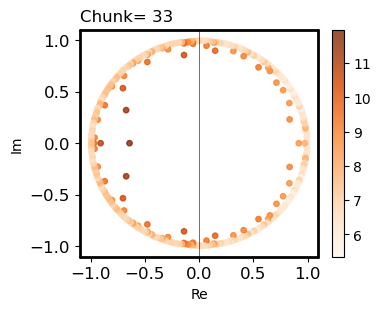

34
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 86.20130375023416 for a  14861.329536480267 and sigma 86.20130375023416

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


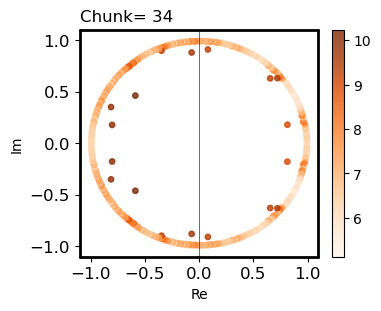

35
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 89.44669104435758 for a  16001.421077569517 and sigma 89.44669104435758

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


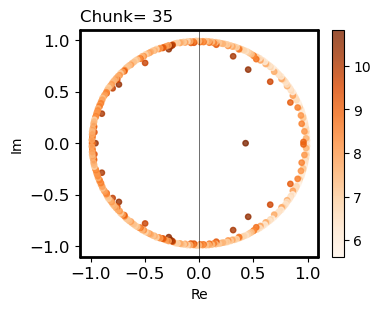

36
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 89.22756795121425 for a  15923.117764977114 and sigma 89.22756795121425

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


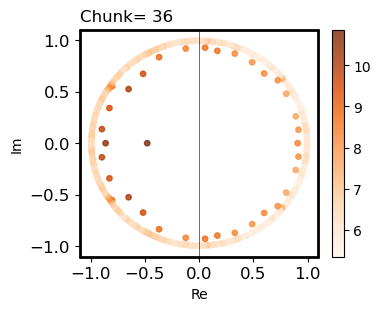

37
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 94.62322184434348 for a  17907.108224407682 and sigma 94.62322184434348

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


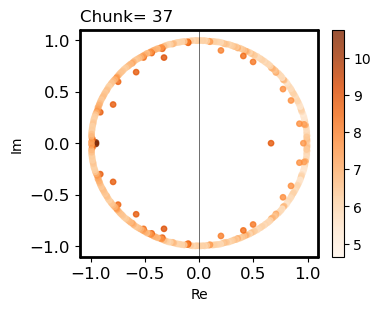

38
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 93.77553513886816 for a  17587.701981162194 and sigma 93.77553513886816

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


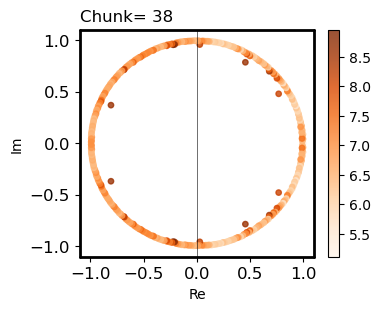

39
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 93.25634020317781 for a  17393.489976181678 and sigma 93.25634020317781

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


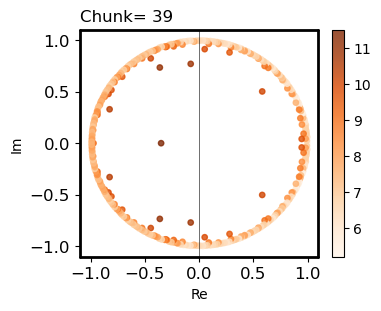

40
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 87.99494008848212 for a  15486.218962351117 and sigma 87.99494008848212

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


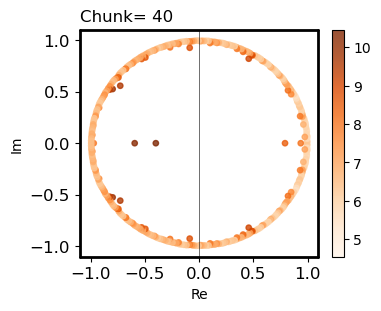

41
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 87.81573168654823 for a  15423.205463287662 and sigma 87.81573168654823

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


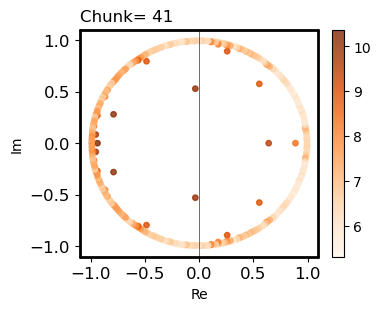

42
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 90.5005626733279 for a  16380.703688377904 and sigma 90.5005626733279

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


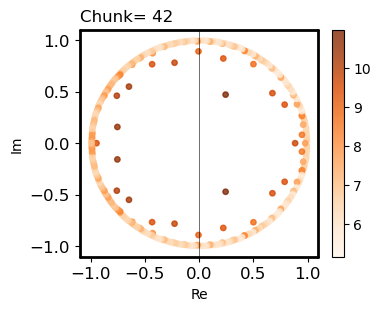

43
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 87.72965340230935 for a  15392.984172178658 and sigma 87.72965340230935

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


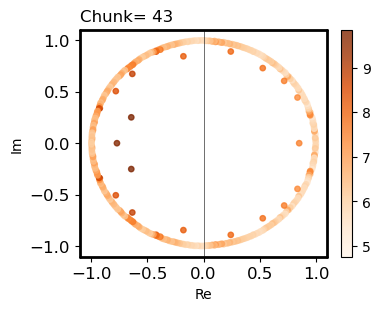

44
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 88.80198462468877 for a  15771.584946566922 and sigma 88.80198462468877

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


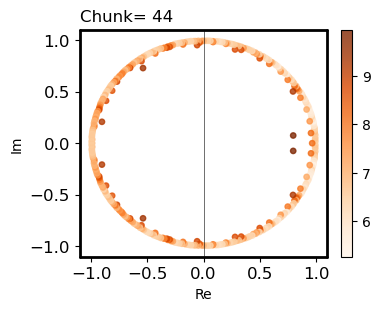

45
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 95.89745950534142 for a  18392.645479157192 and sigma 95.89745950534142

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


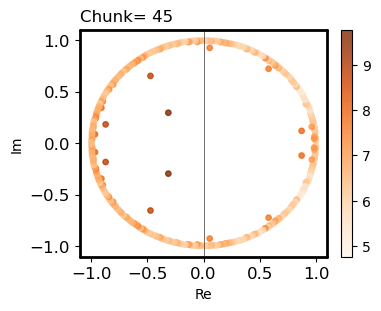

46
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 91.13882989171074 for a  16612.572628060374 and sigma 91.13882989171074

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


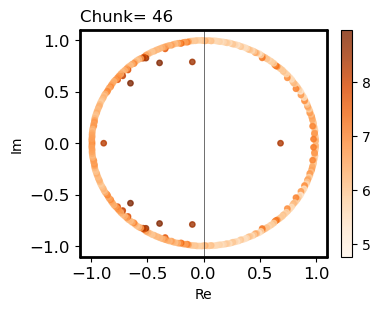

47
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 87.38455831649937 for a  15272.122064339357 and sigma 87.38455831649937

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


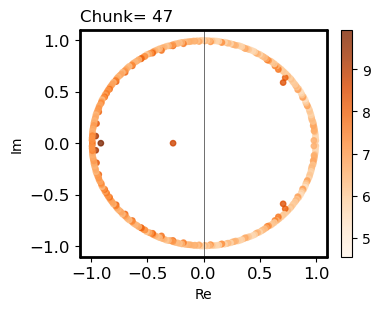

48
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 95.6866209091258 for a  18311.858842013506 and sigma 95.6866209091258

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


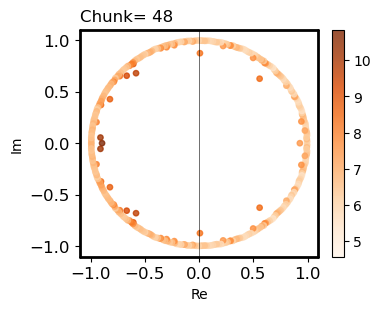

49
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 94.67389938275176 for a  17926.294448670807 and sigma 94.67389938275176

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


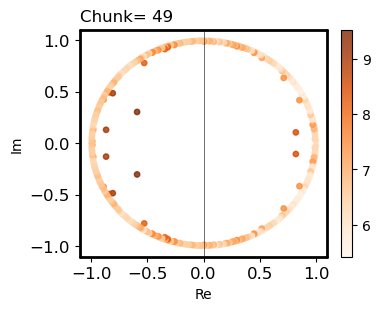

50
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 103.75703986619104 for a  21531.04664358871 and sigma 103.75703986619104

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


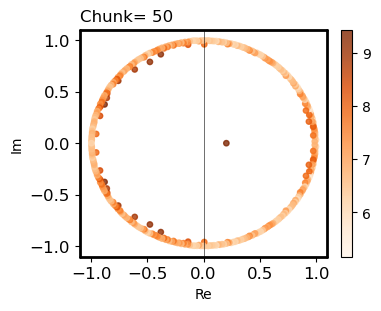

51
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 94.81908257415444 for a  17981.316840408635 and sigma 94.81908257415444

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


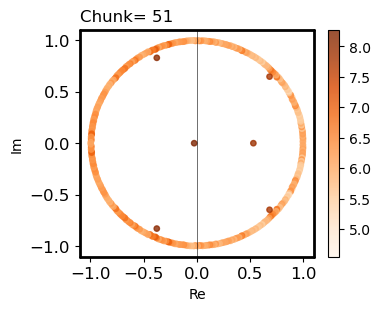

52
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 96.71488382751232 for a  18707.53750753841 and sigma 96.71488382751232

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


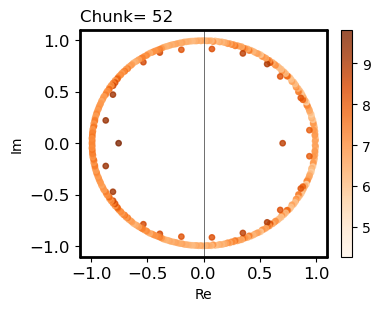

53
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 82.46306507076794 for a  13600.314201731415 and sigma 82.46306507076794

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


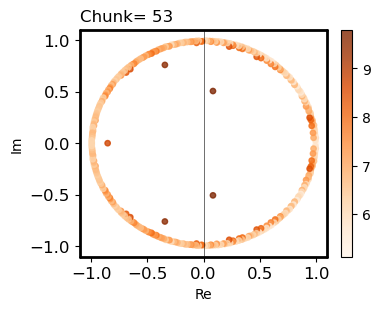

54
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 91.55873021513317 for a  16766.00215721508 and sigma 91.55873021513317

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


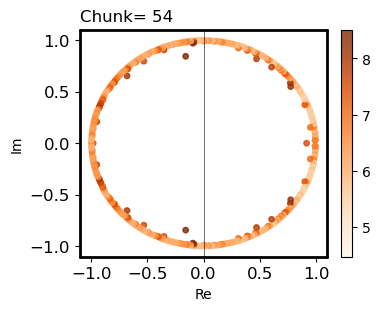

55
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 91.68034480527665 for a  16810.571247228832 and sigma 91.68034480527665

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


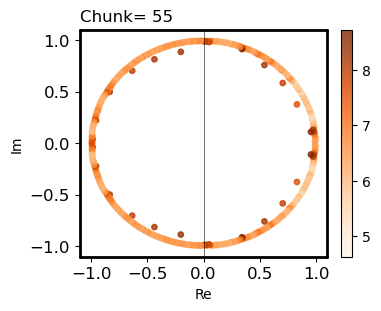

56
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 91.91290633981701 for a  16895.96470366395 and sigma 91.91290633981701

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


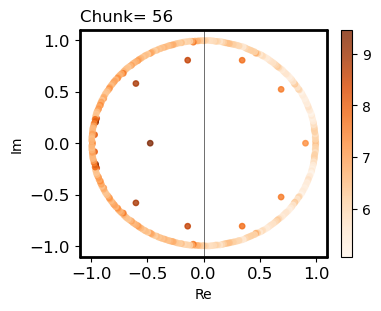

57
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 89.29446929270519 for a  15947.00449253174 and sigma 89.29446929270519

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


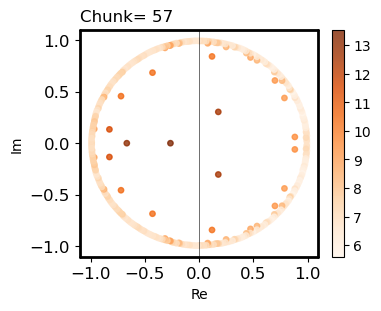

58
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 98.02671749577515 for a  19218.474685993016 and sigma 98.02671749577515

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


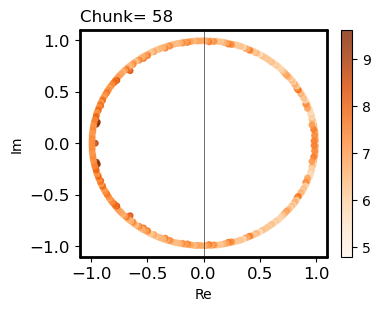

59
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 88.3061683765854 for a  15595.958746707704 and sigma 88.3061683765854

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


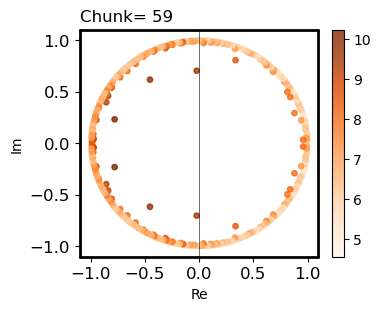

60
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 93.43000037271837 for a  17458.329939292307 and sigma 93.43000037271837

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


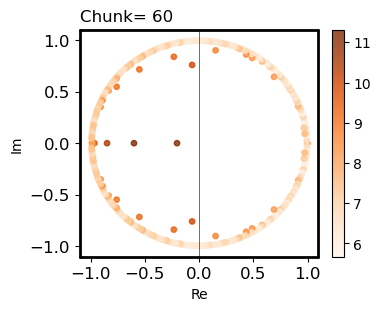

61
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 90.17076757282231 for a  16261.534649343888 and sigma 90.17076757282231

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


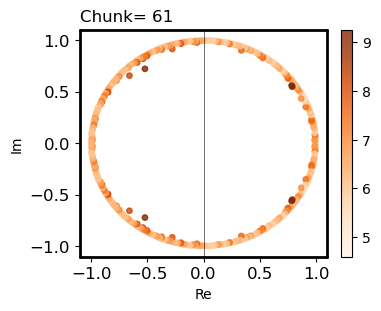

62
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 88.15606689777887 for a  15542.984261771328 and sigma 88.15606689777887

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


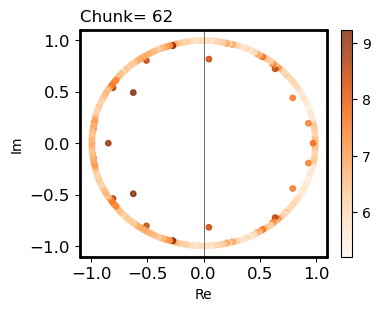

63
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 89.2151314997153 for a  15918.679377022985 and sigma 89.2151314997153

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


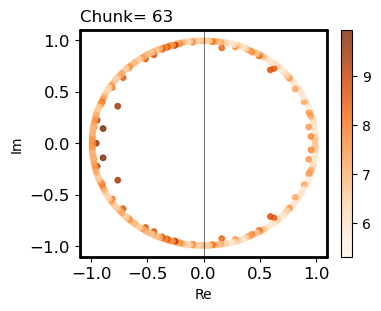

64
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 95.04518639779825 for a  18067.174914784428 and sigma 95.04518639779825

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


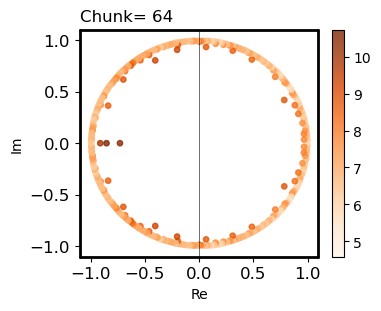

65
Created Koopman Estimator 
 for 359 samples and 1845 features,             1 time interval
 Calculating Koopman Operator 
Using option 90.74057866495095 for a  16467.7052329003 and sigma 90.74057866495095

Computed Transfer Eigenvalues
Computed Kmodes (359, 1845) for (359, 359) normalized eigenfunctions
Computed Kmodes 359 1845 vv  359 359 eigenfunctions
Rank of V matrix 359


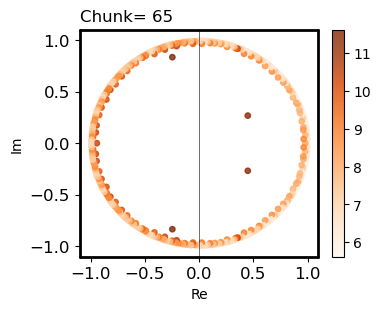

In [24]:
for m in chunks:
    
    nchunk=chunks[m]
    print(nchunk)

    ##################################################################
    #############    FITTING KOOPMAN OPERATOR   ######################
    ##################################################################
    
    PCs_sel=PCs[:,nchunk*360:360+nchunk*360]

    # Creating Koopman operator
    options = {'operator': 'Koopman', 
               'kernel_choice': 'gauss',
               'bandwidth': 'std',
               'epsilon': 1e-5}    #, 'time_data': X_tos_sel.time.data[:-1]
    if encode_svd:
         globals()[f'KK_{nchunk}']=zkop.Koop(PCs_sel,**options)
    else:
        globals()[f'KK_{nchunk}']=zkop.Koop(xdat,**options)

    globals()[f'KK_{nchunk}'].fit(bandwidth=sig[1,m], condition=1e-5)

    # Saving needed variables

    globals()[f'Gxx_{nchunk}']=globals()[f'KK_{nchunk}'].Gxx
    globals()[f'Gxy_{nchunk}']=globals()[f'KK_{nchunk}'].Gxy
    
    PsiX=globals()[f'KK_{nchunk}'].PsiX
    Gxx=globals()[f'KK_{nchunk}'].Gxx

    ww=globals()[f'KK_{nchunk}'].ww
    vv=globals()[f'KK_{nchunk}'].vv
 
    globals()[f'cc_{nchunk}']=globals()[f'KK_{nchunk}'].cc

    ##################################################################
    ##########            COMPUTING MODES         ##################
    ##################################################################

    globals()[f'ds_{nchunk}'] = globals()[f'KK_{nchunk}'].compute_modes(ww,vv,modetype='',description='')
    globals()[f'modes_{nchunk}']=globals()[f'ds_{nchunk}'].kmodes.data

   
    ###########################
    # PLOT EIGENVALUES
    ###########################
    # Find quickly kmodes norms for plotting
    vvnorm = np.log(sc.norm(globals()[f'ds_{nchunk}'].kmodes,axis=0))
    vmax = max(vvnorm)
    vmin = min(vvnorm)
    vscale = (vvnorm - vmin)/(vmax-vmin)

    
    fig,axu = plt.subplots(1, 1,figsize=(3.7,3),constrained_layout=True)
    plt.style.context('fivethirtyeight')
    
    plimz=1.1
    plim = 5
    ar=15
    
    ax = axu
    hh=ax.scatter(globals()[f'ds_{nchunk}'].eigval.real, globals()[f'ds_{nchunk}'].eigval.imag, s=ar,c=vvnorm,cmap='Oranges',alpha=0.8)
    ax.axvline(0, color='black',lw=0.4)
    # ax.set_title(f' Total, $\epsilon$={KK.epsilon}',fontsize=16,loc='left')
    ax.set_xlabel('Re',fontsize = 10)
    ax.set_ylabel('Im',fontsize = 10)
    ax.set_xlim(-plimz,plimz)
    ax.set_ylim(-plimz,plimz)
    plt.colorbar(hh)
    
    zmap.changelabel(axu,fontsize=12,fontfamily='DejaVu Sans',fontweight='normal')
    zmap.changebox(axu,'all',linewidth=2,color='black',capstyle='round')
    
    ax.set_title(f'Chunk= {nchunk}',loc='left')  
    plt.show()

In [25]:
ccs = [cc_0, cc_1, cc_2, cc_3, cc_4, cc_5, cc_6, cc_7, cc_8, cc_9, cc_10, cc_11, cc_12, cc_13, cc_14, cc_15, cc_16, cc_17, cc_18, cc_19, cc_20, cc_21, cc_22, cc_23, cc_24, cc_25, cc_26, cc_27, cc_28, cc_29, cc_30, cc_31, cc_32, cc_33, cc_34, cc_35, cc_36, cc_37, cc_38, cc_39, cc_40, cc_41, cc_42, cc_43, cc_44, cc_45, cc_46, cc_47, cc_48, cc_49, cc_50, cc_51, cc_52, cc_53, cc_54, cc_55, cc_56, cc_57, cc_58, cc_59, cc_60, cc_61, cc_62, cc_63, cc_64, cc_65]
KKs = [KK_0, KK_1, KK_2, KK_3, KK_4, KK_5, KK_6, KK_7, KK_8, KK_9, KK_10, KK_11, KK_12, KK_13, KK_14, KK_15, KK_16, KK_17, KK_18, KK_19, KK_20, KK_21, KK_22, KK_23, KK_24, KK_25, KK_26, KK_27, KK_28, KK_29, KK_30, KK_31, KK_32, KK_33, KK_34, KK_35, KK_36, KK_37, KK_38, KK_39, KK_40, KK_41, KK_42, KK_43, KK_44, KK_45, KK_46, KK_47, KK_48, KK_49, KK_50, KK_51, KK_52, KK_53, KK_54, KK_55, KK_56, KK_57, KK_58, KK_59, KK_60, KK_61, KK_62, KK_63, KK_64, KK_65]
dss = [ds_0, ds_1, ds_2, ds_3, ds_4, ds_5, ds_6, ds_7, ds_8, ds_9, ds_10, ds_11, ds_12, ds_13, ds_14, ds_15, ds_16, ds_17, ds_18, ds_19, ds_20, ds_21, ds_22, ds_23, ds_24, ds_25, ds_26, ds_27, ds_28, ds_29, ds_30, ds_31, ds_32, ds_33, ds_34, ds_35, ds_36, ds_37, ds_38, ds_39, ds_40, ds_41, ds_42, ds_43, ds_44, ds_45, ds_46, ds_47, ds_48, ds_49, ds_50, ds_51, ds_52, ds_53, ds_54, ds_55, ds_56, ds_57, ds_58, ds_59, ds_60, ds_61, ds_62, ds_63, ds_64, ds_65]
modess = [modes_0, modes_1, modes_2, modes_3, modes_4, modes_5, modes_6, modes_7, modes_8, modes_9, modes_10, modes_11, modes_12, modes_13, modes_14, modes_15, modes_16, modes_17, modes_18, modes_19, modes_20, modes_21, modes_22, modes_23, modes_24, modes_25, modes_26, modes_27, modes_28, modes_29, modes_30, modes_31, modes_32, modes_33, modes_34, modes_35, modes_36, modes_37, modes_38, modes_39, modes_40, modes_41, modes_42, modes_43, modes_44, modes_45, modes_46, modes_47, modes_48, modes_49, modes_50, modes_51, modes_52, modes_53, modes_54, modes_55, modes_56, modes_57, modes_58, modes_59, modes_60, modes_61, modes_62, modes_63, modes_64, modes_65]

In [26]:
del(cc_0, cc_1, cc_2, cc_3, cc_4, cc_5, cc_6, cc_7, cc_8, cc_9, cc_10, cc_11, cc_12, cc_13, cc_14, cc_15, cc_16, cc_17, cc_18, cc_19, cc_20, cc_21, cc_22, cc_23, cc_24, cc_25, cc_26, cc_27, cc_28, cc_29, cc_30, cc_31, cc_32, cc_33, cc_34, cc_35, cc_36, cc_37, cc_38, cc_39, cc_40, cc_41, cc_42, cc_43, cc_44, cc_45, cc_46, cc_47, cc_48, cc_49, cc_50, cc_51, cc_52, cc_53, cc_54, cc_55, cc_56, cc_57, cc_58, cc_59, cc_60, cc_61, cc_62, cc_63, cc_64, cc_65)
del(KK_0, KK_1, KK_2, KK_3, KK_4, KK_5, KK_6, KK_7, KK_8, KK_9, KK_10, KK_11, KK_12, KK_13, KK_14, KK_15, KK_16, KK_17, KK_18, KK_19, KK_20, KK_21, KK_22, KK_23, KK_24, KK_25, KK_26, KK_27, KK_28, KK_29, KK_30, KK_31, KK_32, KK_33, KK_34, KK_35, KK_36, KK_37, KK_38, KK_39, KK_40, KK_41, KK_42, KK_43, KK_44, KK_45, KK_46, KK_47, KK_48, KK_49, KK_50, KK_51, KK_52, KK_53, KK_54, KK_55, KK_56, KK_57, KK_58, KK_59, KK_60, KK_61, KK_62, KK_63, KK_64, KK_65)
del(ds_0, ds_1, ds_2, ds_3, ds_4, ds_5, ds_6, ds_7, ds_8, ds_9, ds_10, ds_11, ds_12, ds_13, ds_14, ds_15, ds_16, ds_17, ds_18, ds_19, ds_20, ds_21, ds_22, ds_23, ds_24, ds_25, ds_26, ds_27, ds_28, ds_29, ds_30, ds_31, ds_32, ds_33, ds_34, ds_35, ds_36, ds_37, ds_38, ds_39, ds_40, ds_41, ds_42, ds_43, ds_44, ds_45, ds_46, ds_47, ds_48, ds_49, ds_50, ds_51, ds_52, ds_53, ds_54, ds_55, ds_56, ds_57, ds_58, ds_59, ds_60, ds_61, ds_62, ds_63, ds_64, ds_65)
del(modes_0, modes_1, modes_2, modes_3, modes_4, modes_5, modes_6, modes_7, modes_8, modes_9, modes_10, modes_11, modes_12, modes_13, modes_14, modes_15, modes_16, modes_17, modes_18, modes_19, modes_20, modes_21, modes_22, modes_23, modes_24, modes_25, modes_26, modes_27, modes_28, modes_29, modes_30, modes_31, modes_32, modes_33, modes_34, modes_35, modes_36, modes_37, modes_38, modes_39, modes_40, modes_41, modes_42, modes_43, modes_44, modes_45, modes_46, modes_47, modes_48, modes_49, modes_50, modes_51, modes_52, modes_53, modes_54, modes_55, modes_56, modes_57, modes_58, modes_59, modes_60, modes_61, modes_62, modes_63, modes_64, modes_65)

In [27]:
ccs=np.array(ccs)
KKs=np.array(KKs)
modess=np.array(modess)

# Computhe phis

In [7]:
chunks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65]
#chunks
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
#periods

In [43]:
%%time
for m in periods: 
    for j in chunks:
        # Select period we want to forecast and operator we want to use 
        op=j        
        
        #Choosing forecasting elements
        if op=='KK_syn':
            
            cc= KK_syn.cc
            KK= KK_syn
            ds= A_ds
            modes= A_ds.kmodes
            
        elif ((op>= 0) or (op<= 65)):
            cc= ccs[op]
            KK= KKs[op]
            #ds= dss[op]
            #modes= modess[op]

        
        tstep=1
        cases=range(0,1200)
        nmode=359      #modes.shape[1]
        phix=np.zeros([nmode,len(cases)],dtype='complex')
        
        for i in cases:
            
            nstart=i+(1200*m)
            x0=PCs[:,nstart]
            phix[:,i]= eigenfunction_value_opt1(cc, KK, x0)
        
        print('period=  ', m, '  operator:', j)
        np.save(f'Phix 30/Phix_ALLEOFs_p{m}_o{op}', phix, allow_pickle=True, fix_imports=True)

period=   0   operator: 0
period=   0   operator: 1
period=   0   operator: 2
period=   0   operator: 3
period=   0   operator: 4
period=   0   operator: 5
period=   0   operator: 6
period=   0   operator: 7
period=   0   operator: 8
period=   0   operator: 9
period=   0   operator: 10
period=   0   operator: 11
period=   0   operator: 12
period=   0   operator: 13
period=   0   operator: 14
period=   0   operator: 15
period=   0   operator: 16
period=   0   operator: 17
period=   0   operator: 18
period=   0   operator: 19
period=   0   operator: 20
period=   0   operator: 21
period=   0   operator: 22
period=   0   operator: 23
period=   0   operator: 24
period=   0   operator: 25
period=   0   operator: 26
period=   0   operator: 27
period=   0   operator: 28
period=   0   operator: 29
period=   0   operator: 30
period=   0   operator: 31
period=   0   operator: 32
period=   0   operator: 33
period=   0   operator: 34
period=   0   operator: 35
period=   0   operator: 36
period=   0

# Forecasts

In [87]:
#load_for=[0,1,2,3,4] #p=0  
#load_for=[5,6,7,8,9] #p=1
#load_for=[10,11,12,13,14] #p=2
#load_for=[15,16,17,18,19] #p=3
#load_for=[20,21,22,23,24] #p=4
#load_for=[25,26,27,28,29] #p=5
#load_for=[30,31,32,33,34] #p=6
#load_for=[35,36,37,38,39] #p=7
#load_for=[40,41,42,43,44] #p=8
#load_for=[45,46,47,48,49] #p=9
#load_for=[50,51,52,53,54] #p=10
#load_for=[55,56,57,58,59] #p=11
load_for=[60,61,62,63,64] #p=12

p=12

phix_tot=np.zeros((5, 359, 1800), dtype=complex)


for n in range(len(load_for)):
    i=load_for[n]
    if ((p % 2) == 0):
        phix_tot[n,:,0:1200]= np.load(f'Phix 30/Phix_ALLEOFs_p{int(p+p/2)}_o{i}.npy')
        phix_tot[n,:,1200:1800]= np.load(f'Phix 30/Phix_ALLEOFs_p{int(p+1+p/2)}_o{i}.npy')[:,0:600]
        print('even ',p, int(p+p/2), int(p+1+p/2))
    else:
        phix_tot[n,:,0:600]= np.load(f'Phix 30/Phix_ALLEOFs_p{int(p+(p-1)/2)}_o{i}.npy')[:,600:1800]
        phix_tot[n,:,600:1800]= np.load(f'Phix 30/Phix_ALLEOFs_p{int(p+1+(p-1)/2)}_o{i}.npy')
        print('odd ',p, int(p+(p-1)/2), int(p+1+(p-1)/2))

even  12 18 19
even  12 18 19
even  12 18 19
even  12 18 19
even  12 18 19


In [88]:
tstep=1
tim_level=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
nmode=modess[0].shape[1]
cases=range(0,1800-24)
forecast=np.empty([5,PCs_sel.shape[0],24,len(cases)])
forecast[:] = np.nan

In [89]:
%%time
for n in range(len(load_for)):
    c=load_for[n]

    op=c         #Either KK_syn or a number from 0 to 20
    cc= ccs[op]
    KK= KKs[op]
    ds= dss[op]
    modes= modess[op]
    eigs=ds.eigval

    eig_tot=np.zeros([len(tim_level),phix_tot.shape[1],phix_tot.shape[1]],dtype='complex')

    for x in tim_level:
        eig_tot[x,:,:]=np.diag(eigs**(x*tstep))

    if n==0:
        subcases=np.delete(cases, range(n*360, n*360+360))

    if (n>=1 and n<=3):
        subcases=np.delete(cases, range(n*360-24, n*360+360))
    
    if n==4:
        subcases=np.delete(cases, range(n*360-24, n*360+360-24))
        
    for i in subcases:

        nstart=i
        phix = phix_tot[n,:,i]
        eigvals=np.diag(eigs[:nmode]**(tstep)) 
        ht=np.zeros([1845,24],dtype='complex')

        #Evolution
        for j in tim_level:
            eigvals=eig_tot[j,:,:]                   
            ht[:,j]=modes @ eigvals @ phix

        forecast[n,:,:,i]=ht
    
    print(c)
        
np.save(f'150 years testing/150 years testing-Forecasts 30/ALLEOFs_forecast_p{p}', forecast, allow_pickle=True, fix_imports=True)

60
61
62
63
64
CPU times: user 2h 48min 22s, sys: 1min 4s, total: 2h 49min 27s
Wall time: 2min 22s


forecast[0,0,0,600:2376] # 0 600-2400 OK

forecast[1,0,0,1800:2376] #1 0-576 + 1200-2400 OK

forecast[2,0,0,1800:2376] #1 0-1177 + 1200-2400 OK

forecast[3,0,0,1770:1810]

# Evaluation

In [90]:
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [91]:
tot_for=np.load('150 years testing/150 years testing-Forecasts 30/ALLEOFs_forecast_p10.npy')

In [92]:
flabel = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':18,'fontweight':'bold'}   #,'fontfamily':'Futura',

## Leads

In [93]:
for_levels=[0,1,2,3,4]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

In [94]:
tot_for.shape

(5, 1845, 24, 1776)

In [95]:
mean_av=np.zeros(24)
mean_ind=np.zeros((24,5))

In [96]:
Jrmse_mean_av=np.zeros(24)
Jrmse_mean_ind=np.zeros((24,5))

In [97]:
#Select period
m=10
udat_sst=EOFs[:,0:845]
X_tos_sel=X_tos.A[:,m*1800:1800+m*1800]

In [98]:
## Compute observations NON truncated to PCs
Xindex=X_tos_sel.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))[:-1]
Xindex

<xarray.DataArray (time: 1799)>
array([ 0.01697374,  0.19405715,  0.39850056, ..., -0.21654455,
       -0.34899217, -0.26335007], dtype=float32)
Coordinates:
  * time     (time) object 1501-02-01 00:00:00 ... 1650-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 2 3 4 5 6 7 8 9 10 11 12

In [99]:
import numpy.ma as ma

0.9431970423471465
0.9362464848431253
0.6213962393798793
0.6140773511071698


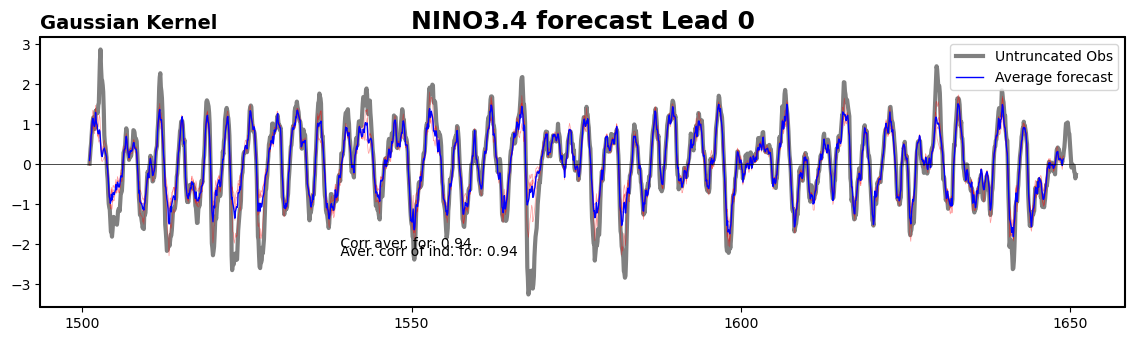

0.9322441483702447
0.9219825712179052
0.592766061441327
0.580444013282179


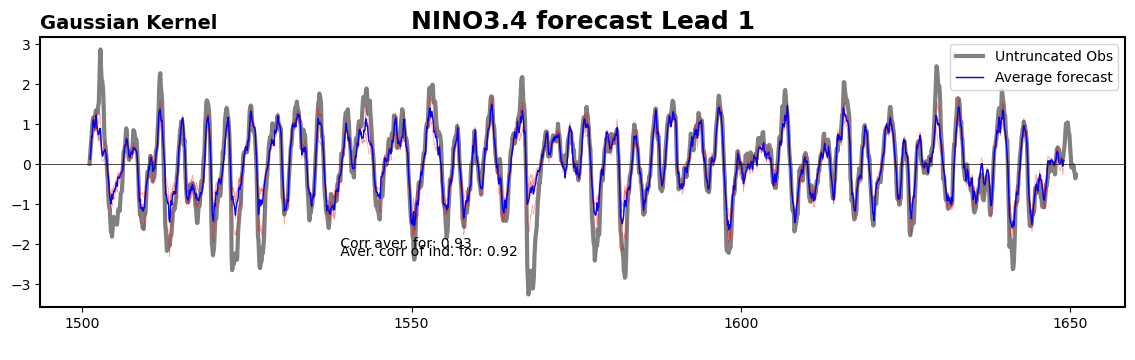

0.9142131337126098
0.9008280915411027
0.5571894631645042
0.5406236881038564


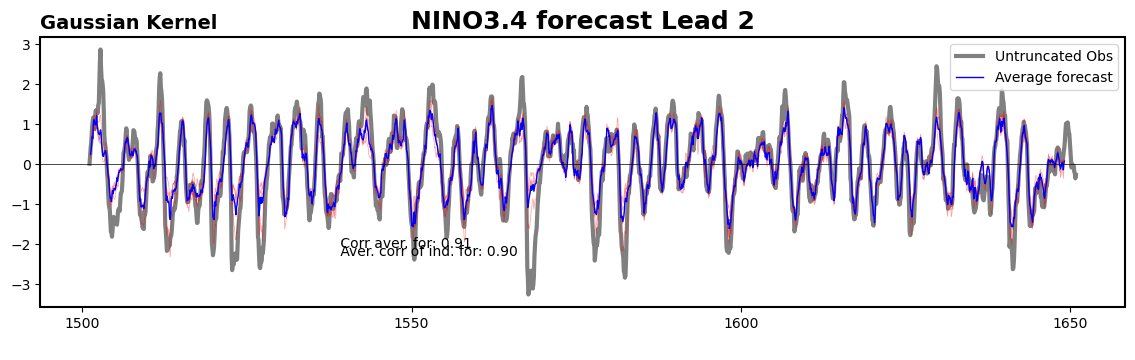

0.8927873938223523
0.873854295670791
0.5176736779220079
0.4963783783664004


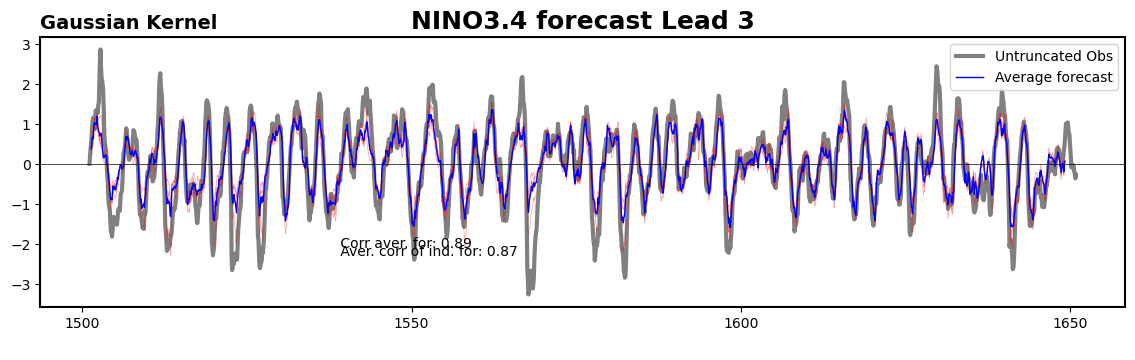

0.8685974965657453
0.8431676022836652
0.47834826413220644
0.45403691185776685


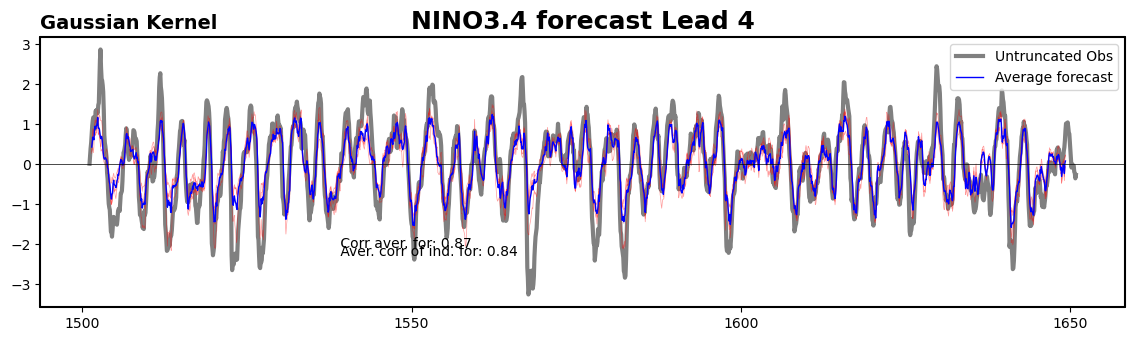

0.8407953482311267
0.8057491557129135
0.4367457800278346
0.40784443010396976


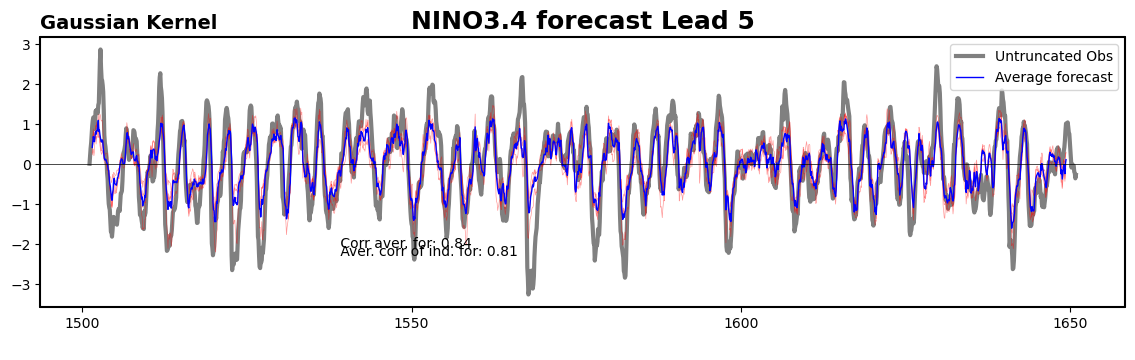

0.8051598853649392
0.7563194049868442
0.39024557361097245
0.3551858649872542


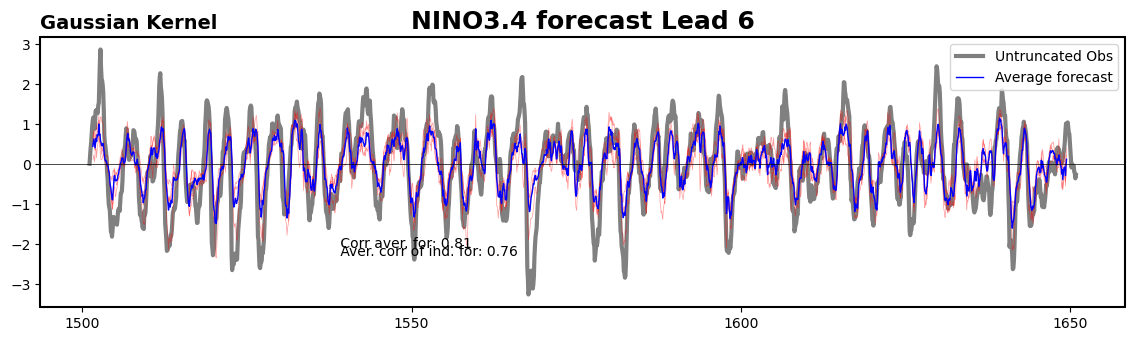

0.7645834376686048
0.7004283595490766
0.3449672917635702
0.3059555086773874


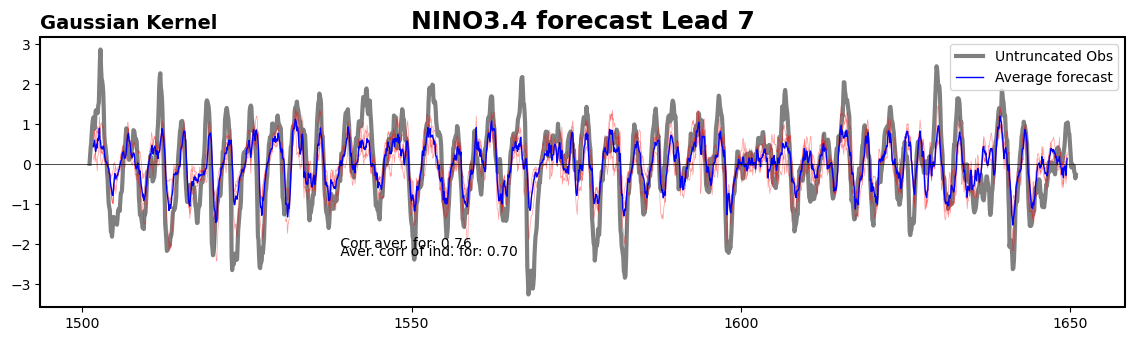

0.7238189115841999
0.6449119576859514
0.3054474456196937
0.26165016727830576


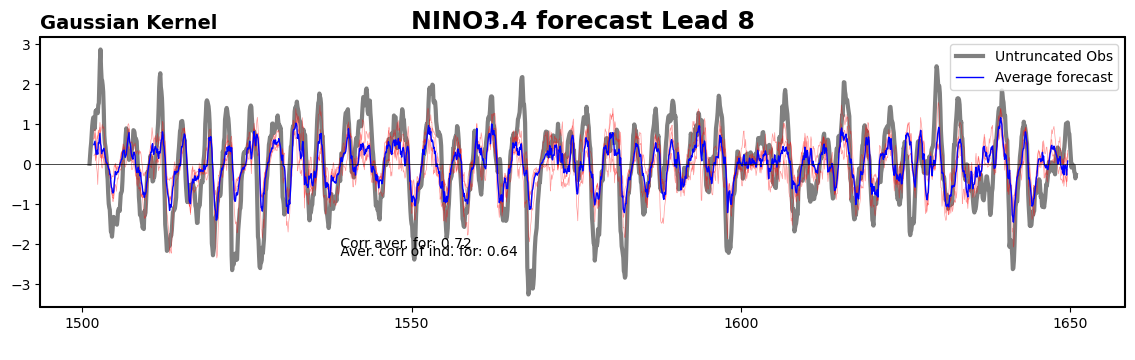

0.6881531009308179
0.6057523759523373
0.27926607398432746
0.23406352639623523


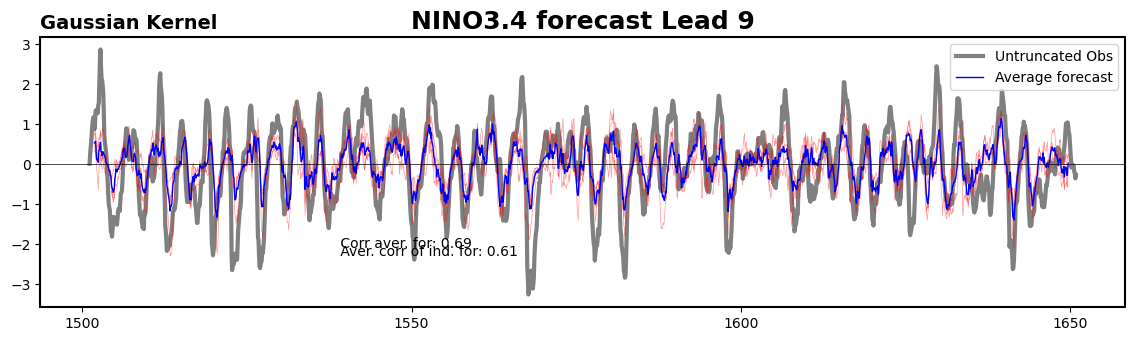

0.6523469197247426
0.5636863932342888
0.25385006337289107
0.2050705089343659


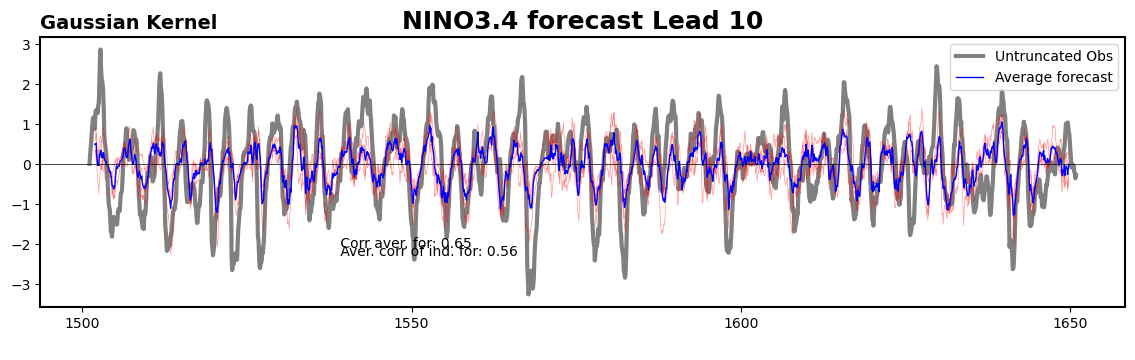

0.6177517706468358
0.5303702111019317
0.23344692594333727
0.1827118717574394


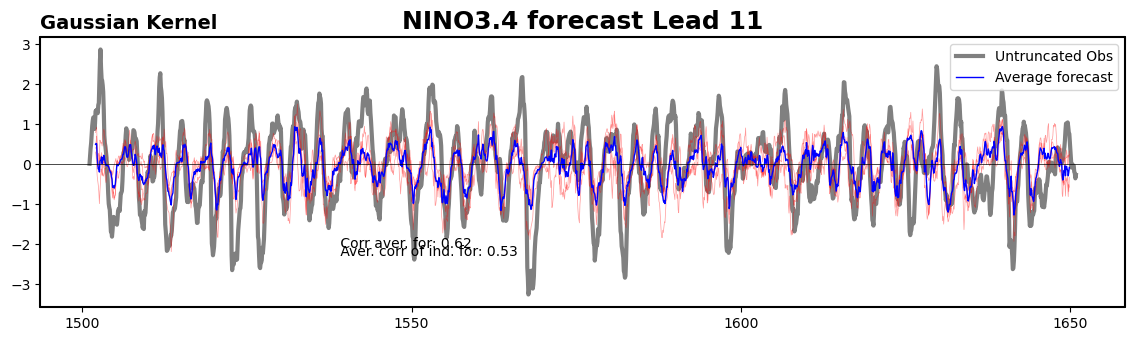

0.5798849564632684
0.49255953197014435
0.21285707272624754
0.16041296364877158


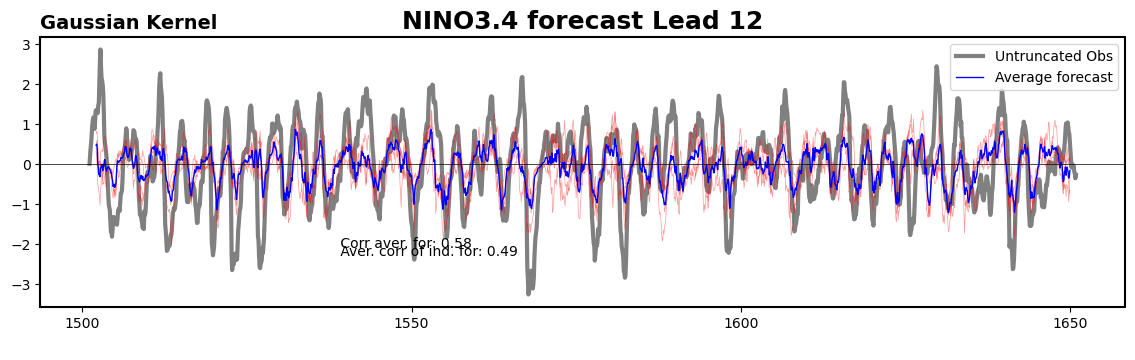

0.5560422018402538
0.47468503348255053
0.20113342214544738
0.14892625373914853


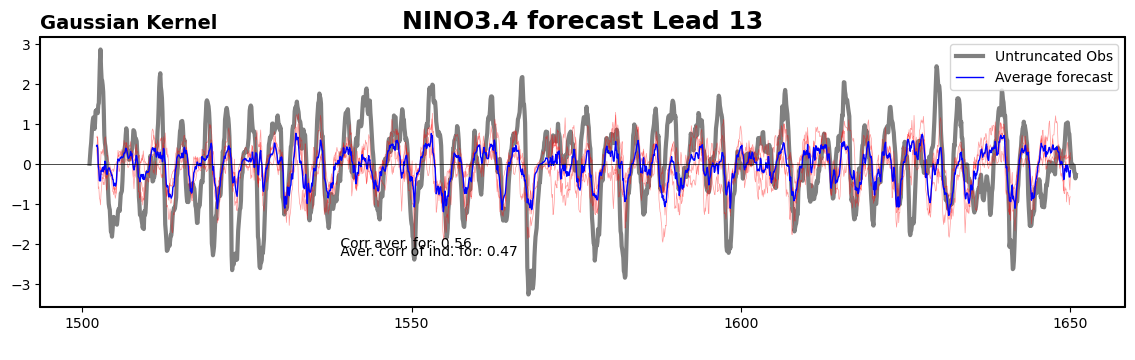

0.5295355275328928
0.4495206862409205
0.1884533856932189
0.13503427219613373


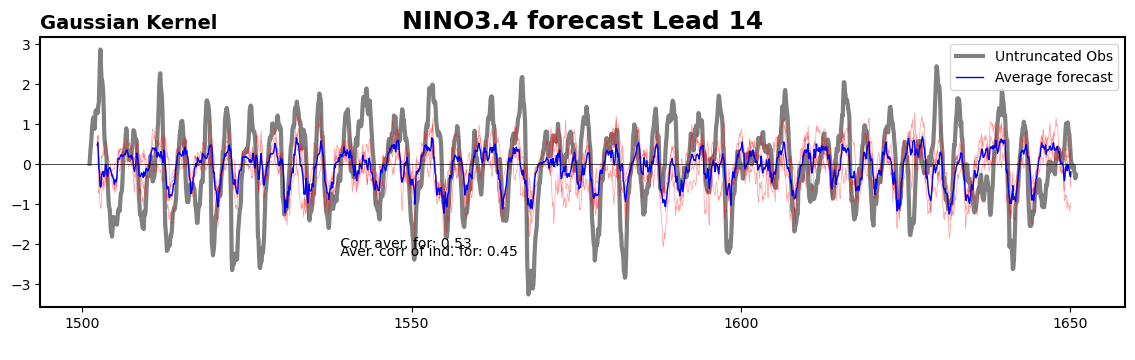

0.5010164330133262
0.4253364899364911
0.17508068356638218
0.12106592848052881


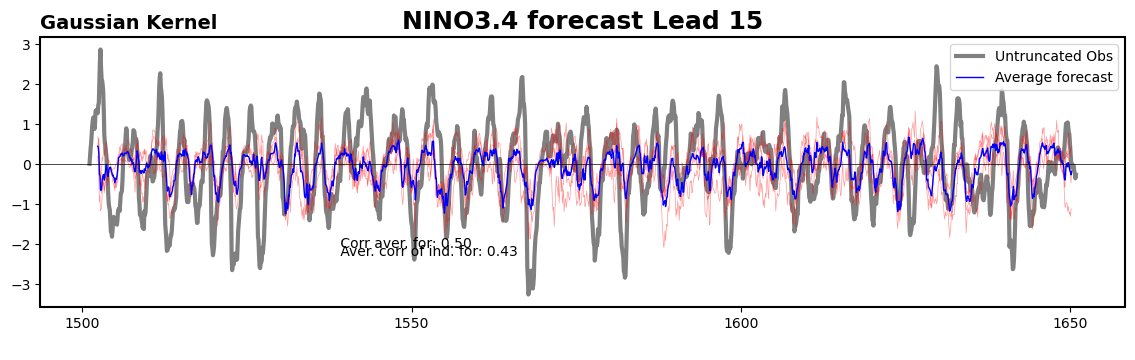

0.4666749871585803
0.39498922960724336
0.15971275148980424
0.10179328084335985


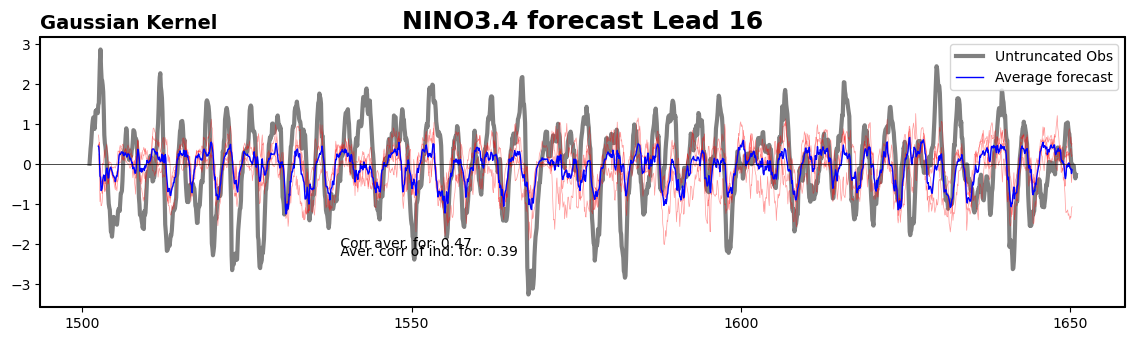

0.44418963371145515
0.37232360737968195
0.14972806871646538
0.0944796777965056


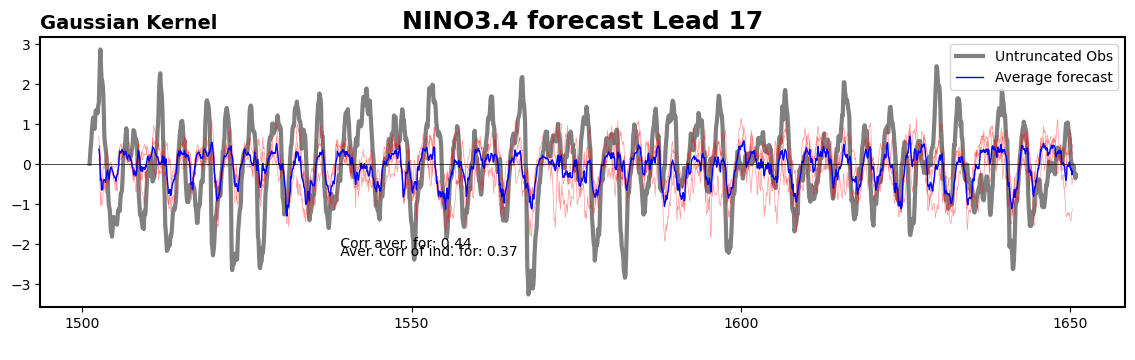

0.4155379083678748
0.3450690769412318
0.13780177195322763
0.0831953264917596


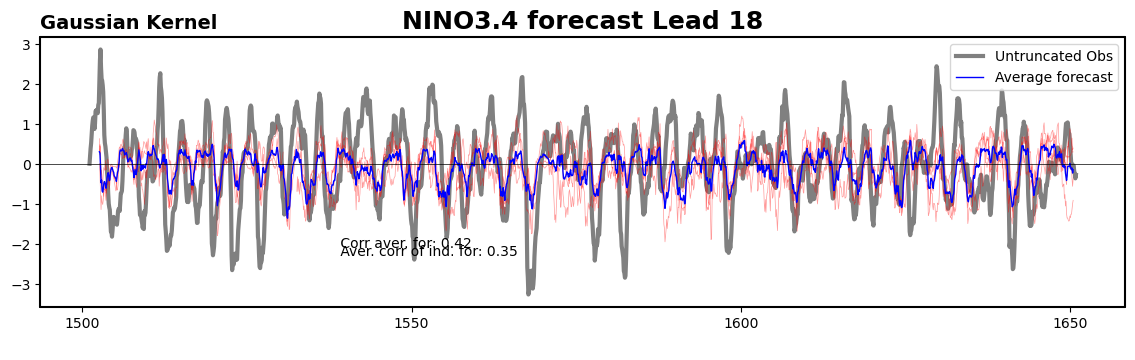

0.39053816064829355
0.32180398523907516
0.12795707618694696
0.07275115488564896


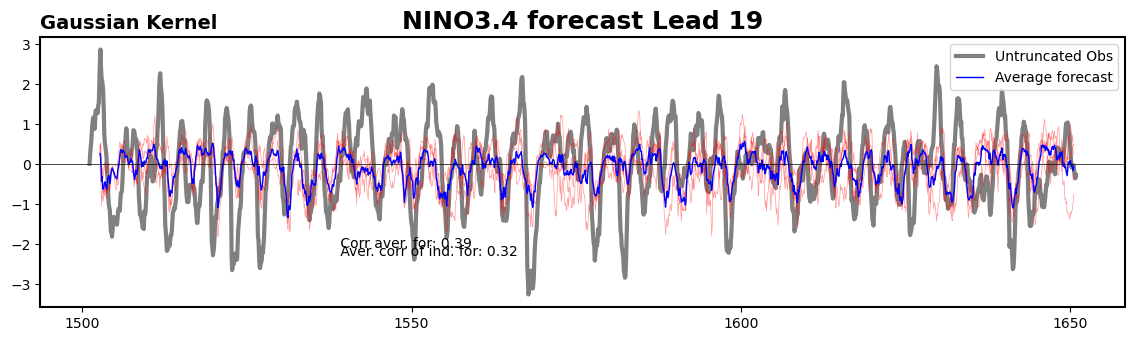

0.3668060557043437
0.29820847243908005
0.11873263157219383
0.06395265555191751


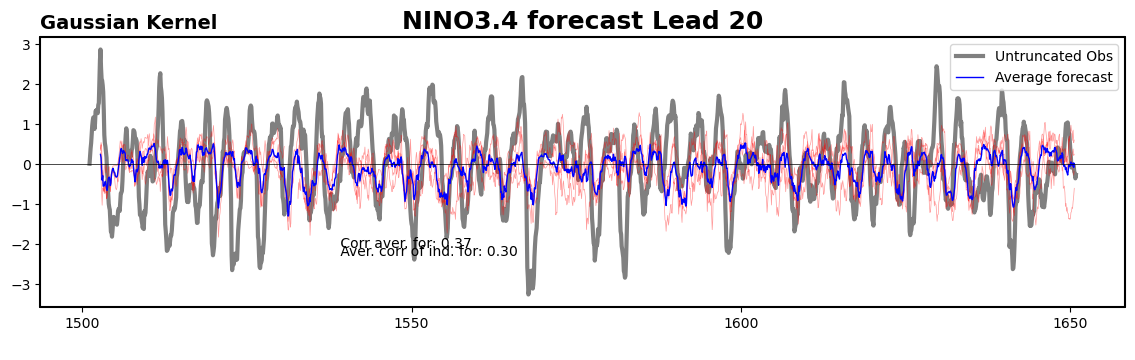

0.34120912054905966
0.2759138828786234
0.10939034929080993
0.052997929908288444


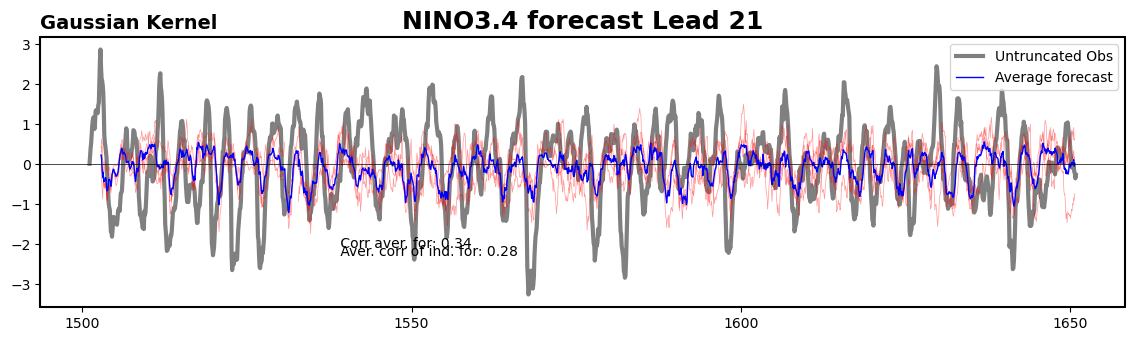

0.320094779508017
0.25824535398805887
0.10190813138826005
0.04721756366352734


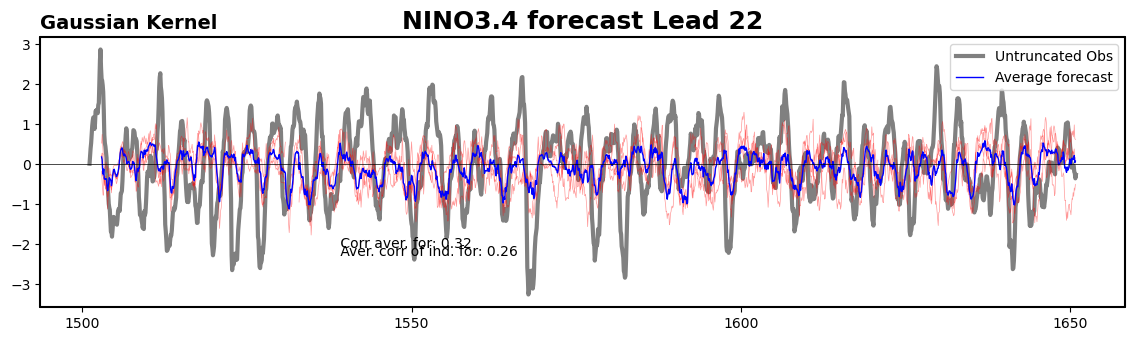

0.2999329239273351
0.24047766151173616
0.09470916406668473
0.04096663107569611


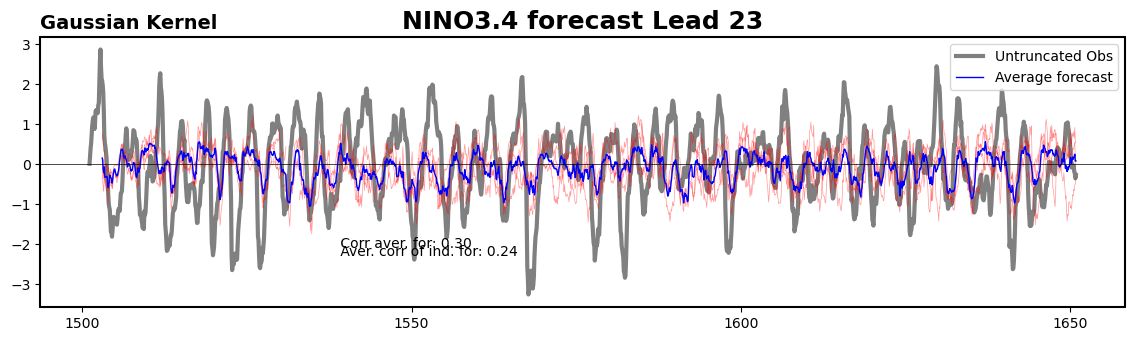

In [100]:
for n in lead_times:

    lead=n

    '''## Compute observations truncated to PCs
    x_pcs_array=udat_sst @ PCs[0:1000,:]
    x_pcs=xr.full_like(X_tos_sel,0)
    x_pcs.data=x_pcs_array
    XindexPCs=x_pcs.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))[:-1]'''

    ## Compute average forecast
    av_for=np.nanmean(tot_for, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
    av_for_geo = xr.full_like(X_tos_sel[:,0+lead:1776+lead],0)
    av_for_geo.data=av_for_geo_array.real
    Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    #Correlation average forecast and observations
    mean_av[lead]=np.corrcoef(Xindex[0+lead:1776+lead],Avindex)[0,1]
    print(mean_av[lead])

    #Average correlation between individual forecast and observations
    for i in range(5):  
        phix_geo_array=udat_sst @ tot_for[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1776+lead],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        mean_ind[lead,i]=ma.corrcoef(ma.masked_invalid(Xindex[0+lead:1776+lead]),ma.masked_invalid(Phiindex))[0,1]

    av_corr=np.mean(mean_ind, axis=1)[lead]
    print(av_corr)
    

    #JAKOB RMSE average forecast and observations
    Jrmse_mean_av[lead]=1-np.sqrt(np.square(np.subtract(Xindex[0+lead:1776+lead],Avindex)).mean()) / np.std(Xindex[0+lead:1190+lead])
    print(Jrmse_mean_av[lead])

    #Average error between individual forecast and observations

    for i in range(5):  
        phix_geo_array=udat_sst @ tot_for[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1776+lead],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        Jrmse_mean_ind[lead,i]= 1-np.sqrt(np.square(np.subtract(Xindex[0+lead:1776+lead],Phiindex)).mean()) / np.std(Xindex[0+lead:1190+lead])


    Jav_rmse=np.mean(Jrmse_mean_ind, axis=1)[lead]
    print(Jav_rmse)
    
    #Plot
    import nc_time_axis

    fig, ax = plt.subplots(1, 1, figsize=(14,3.5),squeeze=False)

    #XindexPCs.plot(label='Obs data (PCs)',lw=3,color='gray')
    Xindex.plot(label='Untruncated Obs',lw=3,color='gray')

    for i in for_levels:  
        #Expand forecast to geographical domain
        phix_geo_array=udat_sst @ tot_for[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1776+lead],0)
        phix_geo.data=phix_geo_array.real

        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        Phiindex.plot(lw=0.5, color='red', alpha=0.4)

    Avindex.plot(label='Average forecast',lw=1,color='blue')

    plt.axhline(0,color='black',lw=0.5)
    plt.title(f'NINO3.4 forecast Lead {lead}',ftitle)
    plt.title(f'Gaussian Kernel',loc='left',**flabel)
    plt.xlabel(' ')
    plt.legend(loc='upper right')
    zmap.changebox(plt.gca(),'all',linewidth=1.5)
    #loctime = Xindex.sel(time='1-JAN-2000').time.data
    cstr1 = f' Corr aver. for: {mean_av[lead]:>.2f}'
    cstr2 = f' Aver. corr of ind. for: {av_corr:>.2f}'
    loctime = Xindex.isel(time=450).time.data
    plt.text(loctime,-2.1,cstr1)
    plt.text(loctime,-2.3,cstr2)
    #labfile =  f'{data_name}{case}_NINO3BANDA_{KK.kernel_choice}{tolone}.pdf'
    #plt.savefig(labfile, orientation='landscape',  format='pdf')
    plt.show()
